In [5]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.cross_validation import KFold


import matplotlib.pyplot as plt


import pandas
import os

%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}
plt.ioff()    # this stops the graphs from overwriting each other

In [6]:
feature_file   = "data/brent_srilm_features.csv"
my_data = pandas.read_csv(feature_file)

my_data = my_data.dropna()
my_data = my_data.reset_index(drop=True)
my_data = my_data

# y will be the same for all feature sets, so we can define it here globally
y       = preprocessing.scale(my_data["y"])


In [7]:
def plot(x, y, regression, labels=[]):
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Data')
    ax.scatter(x, y)

    ax.plot(x, regression, label='regression line', lw=2.)
    
    if len(labels) == len(x):
        for ll, x, y in zip(labels, x, y):
            plt.annotate(
                ll,
                fontsize=4,
                xy=(x, y), xytext=(0, 1),
                textcoords='offset points', ha='right', va='bottom')

    plt.legend(loc=0)
    fig.show()
    plt.close(fig)

In [8]:
def regress(method,xtrain,ytrain,xtest,ytest,features):
    
    if method =="linear":
        reg = LinearRegression(fit_intercept = False, normalize = False)
    elif method =="ridge":
        reg = Ridge(alpha = 1, fit_intercept = False, normalize = False)
    elif method =="ridgecv":
        reg = RidgeCV(alphas = [0.0001,0.001,0.01,0.1,1,10,100], fit_intercept = False, normalize = False)
    else:
        print("Invalid method choose from {linear, ridge, ridgecv}")
        return

    reg.fit(xtrain, ytrain)

    y_predict  = reg.predict(xtest)

    mmse = np.mean((y_predict - ytest) ** 2)
    r2  = reg.score(xtest, ytest)
    
    if len(features) == 1:
        plot(xtrain, ytrain, reg.predict(xtrain))
        
    return mmse, r2, reg.coef_

In [9]:
def regress_cv(method,xx,yy,features,n_folds=10,seed=5):
    
    #fix seed for reproducability
    np.random.seed(seed)
    
    if method =="linear":
        reg = LinearRegression(fit_intercept = False, normalize = False)
    elif method =="ridge":
        reg = Ridge(alpha = 1, fit_intercept = False, normalize = False)
    elif method =="ridgecv":
        reg = RidgeCV(alphas = [0.0001,0.001,0.01,0.1,1,10,100], fit_intercept = False, normalize = False)
    else:
        print("Invalid method choose from {linear, ridge, ridgecv}")
        return

    cv_mse    = 0.0
    cv_r2 = 0.0
    
    for ii in range(n_folds):
        
        # split in 90% train and 10%test
        mask =  np.random.rand(len(xx)) < 0.9
        
        this_xtrain = xx[mask]
        this_xtest  = xx[~mask]
        this_ytrain = yy[mask]
        this_ytest  = yy[~mask]
        
        reg.fit(this_xtrain, this_ytrain)

        y_predict  = reg.predict(this_xtest)

        mse = np.mean((y_predict - this_ytest) ** 2)
        r2  = reg.score(this_xtest, this_ytest)
    
        cv_mse += mse
        cv_r2 += r2
    
    return cv_mse/float(n_folds), cv_r2/float(n_folds)

['freq'] 0.944637430049
['freq', 'w1'] 0.941450209513
['freq', 'w1w2'] 0.940576301693
['freq', 'p0w1'] 0.94143309334
['freq', 'p0w1w2'] 0.948252521014
['freq', 'p0p1w1'] 0.941254220827
['freq', 'p0p1w1w2'] 0.94779791649
['freq', 'w1', 'w1w2'] 0.937433037917
['freq', 'p0w1', 'p0w1w2'] 0.945196486602
['freq', 'p0p1w1', 'p0p1w1w2'] 0.944993773241
['freq', 'p0w1', 'p0w1w2', 'p0p1w1', 'p0p1w1w2'] 0.943975319127
['freq', 'w1', 'w1w2', 'p0w1', 'p0w1w2', 'p0p1w1', 'p0p1w1w2'] 0.939351439053


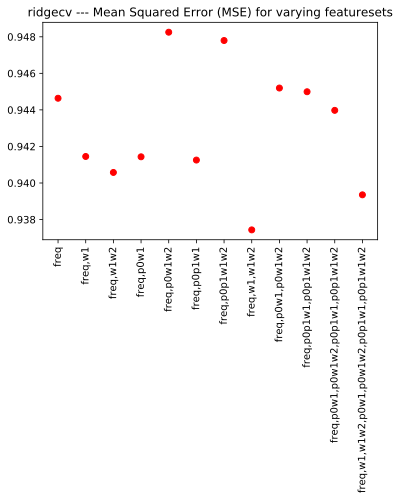

In [10]:
featuresets = [['freq'], ['freq','w1'], ['freq','w1w2'], 
               ['freq','p0w1'], ['freq','p0w1w2'], ['freq','p0p1w1'],
               ['freq','p0p1w1w2'], 
               ['freq','w1','w1w2'],
               ['freq','p0w1','p0w1w2'],
               ['freq','p0p1w1','p0p1w1w2'],
               ['freq','p0w1','p0w1w2','p0p1w1','p0p1w1w2'],
               ['freq','w1','w1w2','p0w1','p0w1w2','p0p1w1','p0p1w1w2']]

method      = "ridgecv" # options: "linear" ridge" "ridgecv"

mses = []

for features in featuresets:
    
    
    this_x_train       = preprocessing.scale(np.log(my_data[features]))
    this_x_test        = preprocessing.scale(np.log(my_data[features]))[255:]
    
    
#    mse, r2, coefs = regress(method,this_x_train,y[:255],this_x_test,y[255:],features)
    mse, r2,       = regress_cv(method,this_x_train,y,features)    
    
    print(features, mse)
    mses.append(mse)
    
x = list(range(len(mses)))
plt.xticks(x, [','.join(f) for f in featuresets], rotation='vertical')
plt.plot(x, mses, 'ro')
plt.title(method+" --- Mean Squared Error (MSE) for varying featuresets")
plt.show()

In [11]:
# X = np.array([[1, 1, 2], [3, 4, 2], [6, 5, 2], [5, 5, 3]])
# y = np.array([1, 0, 0, 1])
# reg = Ridge(alpha = 1, fit_intercept = True, normalize = True)
# reg.fit(X, y)
# np.hstack((reg.intercept_, reg.coef_))